In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook



import os as os

import matplotlib.pyplot as plt

def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()

In [2]:
import scipy.ndimage as ndimage
from scipy import misc
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
%matplotlib notebook

C:\Users\meyjoh\repos\vlcompimg\compimg\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Inverse-problems-part-1" data-toc-modified-id="Inverse-problems-part-1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inverse problems part 1</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Utility functions</a></span></li><li><span><a href="#Create-example-images" data-toc-modified-id="Create-example-images-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Create example images</a></span></li></ul></li><li><span><a href="#Inverse-filter" data-toc-modified-id="Inverse-filter-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Inverse filter</a></span><ul class="toc-item"><li><span><a href="#No-noise" data-toc-modified-id="No-noise-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>No noise</a></span></li><li><span><a href="#Increasing-noise" data-toc-modified-id="Increasing-noise-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Increasing noise</a></span></li></ul></li><li><span><a href="#Wiener-filter" data-toc-modified-id="Wiener-filter-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Wiener filter</a></span></li><li><span><a href="#Richardson-Lucy-algorithm" data-toc-modified-id="Richardson-Lucy-algorithm-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Richardson-Lucy algorithm</a></span><ul class="toc-item"><li><span><a href="#Gradient-based-RL" data-toc-modified-id="Gradient-based-RL-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Gradient-based RL</a></span></li><li><span><a href="#Multiplicative-RL" data-toc-modified-id="Multiplicative-RL-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Multiplicative RL</a></span></li></ul></li></ul></li></ul></div>

# Inverse problems part 1

In this exercise we will try to implement some of the famous deconvolution algorithms on our own.

Test your filter implementations for different convolution kernels and apply different amounts of random noise to the convolution result before applying the deconvolution algorithms.

### Utility functions

In [3]:
def make_odd_shapes(inp : np.ndarray) -> np.ndarray:
    if (inp.shape[0] % 2 == 0):
        inp = inp[0:-1,:]
    if (inp.shape[1] % 2 == 0):
        inp = inp[:,0:-1]
    return inp

In [4]:
def pad_like(inp : np.ndarray, like : np.ndarray):
    to_pad = tuple(np.int32((np.array(like.shape) - np.array(inp.shape))/2))
    return np.pad(inp, ((to_pad[0], to_pad[0]), (to_pad[1], to_pad[1])))

In [19]:
def mag_square(inp : np.ndarray):
    return inp.real**2 + inp.imag**2

In [5]:
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
    kernel_padded = pad_like(kernel, img)
    kernel_padded_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
    
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

In [6]:
def createPillobxResponse(r, x_size, y_size):
    X,Y = np.meshgrid(np.arange(-1*np.floor(x_size/2),np.floor(x_size/2)+1,1), np.arange(-1*np.floor(y_size/2),np.floor(y_size/2)+1,1))
    psf = np.zeros_like(X)
    psf[np.sqrt(X**2+Y**2) <= r] = 1
    return psf, X, Y

### Create example images

Create an example undistorted image $s$:

In [7]:
s = make_odd_shapes(np.float32(misc.face(gray=True)))

Create a disk-shaped convolution kernel and normalize it:

In [8]:
h,_,_ = createPillobxResponse(20, 51,51)
h = 1/np.sum(h) * h

## Inverse filter

Implement and test the inverse filter.

In [9]:
def inverse_filter(g:np.ndarray, h:np.ndarray) -> np.ndarray:
    g_fft = np.fft.fft2(g)
    h_padded = pad_like(h, g)
    h_fft = np.fft.fft2(np.fft.ifftshift(h_padded))
    inv_fft = g_fft / h_fft
    return np.real(np.fft.ifft2(inv_fft))

### No noise

Test the inverse filter for the absence of noise:

<IPython.core.display.Javascript object>


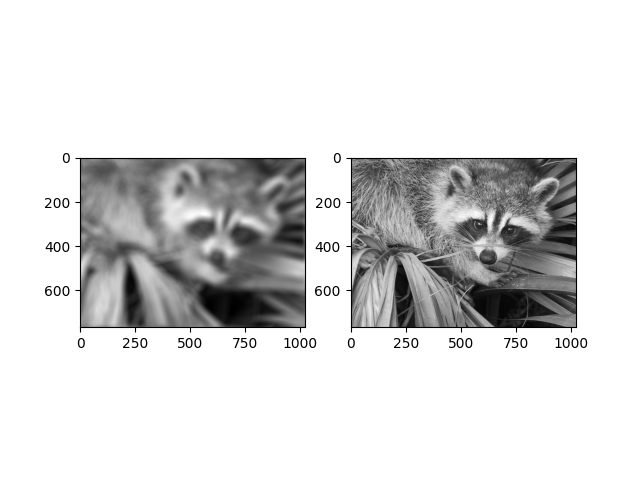

In [10]:
g = ndimage.convolve(s,h, mode='wrap') # Simulate noiseless observation
s_hat = inverse_filter(g, h)           # Perform reconstruction
plt.figure()
plt.subplot(1,2,1)
plt.imshow(g, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(s_hat, cmap='gray')

### Increasing noise

In [11]:
sigmas = np.float32(np.array([0,2,4,8,16,32]))  # Standard deviations for Gaussian noise

In [13]:
g = ndimage.convolve(s,h, mode='wrap')
reconsts_inv = [] # List for reconstructions
noises = []   # List for observations
for sigma in sigmas:
    cur_img = g + np.random.normal(0, sigma, g.shape)
    noises.append(cur_img)
    recon = inverse_filter(cur_img, h)
    reconsts_inv.append(recon)

In [16]:
def plot_inv_filter_result(i):
    plt.subplot(1,2, 1, title=f'Observation $g$ with $\sigma={sigmas[i]}$')
    plt.imshow(noises[i], cmap='gray')
    plt.subplot(1,2, 2, title="Reconstruction with inverse filter")
    plt.imshow(reconsts_inv[i], cmap='gray')
    plt.tight_layout()

<IPython.core.display.Javascript object>


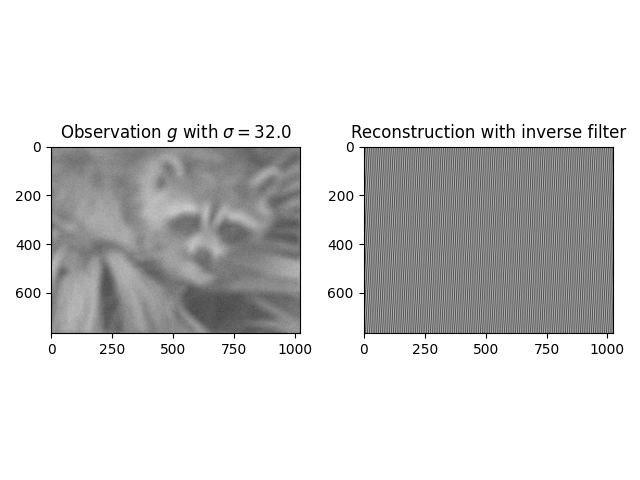

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [18]:
plt.figure()
interact(lambda i: plot_inv_filter_result(i), i=widgets.IntSlider(min=(min_i:=0),max=(max_i:=len(reconsts_inv)-1), step=1, value=0))

## Wiener filter

Implement and test the Wiener filter. To estimate the SNR, use the heuristic described in the lecture.

In [20]:
def wiener_filter(g:np.ndarray, h:np.ndarray) -> np.ndarray:
    g_fft = np.fft.fft2(g)
    h_padded = pad_like(h, g)
    h_fft = np.fft.fft2(np.fft.ifftshift(h_padded))
    
    X,Y = np.meshgrid(np.arange(1,g.shape[1]+1), np.arange(1,g.shape[0]+1))
    
    snr = (1 / np.sqrt(X**2 + Y**2))
    
    inv_fft = g_fft * np.conjugate(h_fft) / (mag_square(h_fft) + snr)
    return np.real(np.fft.ifft2(inv_fft))

In [21]:
wiener_reconsts = []
for cur_img in noises:
    recon = wiener_filter(cur_img, h)
    wiener_reconsts.append(recon)

In [22]:
def plot_wiener_filter_result(i):
    plt.subplot(1,2, 1, title=f'Observation $g$ with $\sigma={sigmas[i]}$')
    plt.imshow(noises[i], cmap='gray')
    plt.subplot(1,2, 2, title="Reconstruction with Wiener filter")
    plt.imshow(wiener_reconsts[i], cmap='gray')
    plt.tight_layout()

<IPython.core.display.Javascript object>


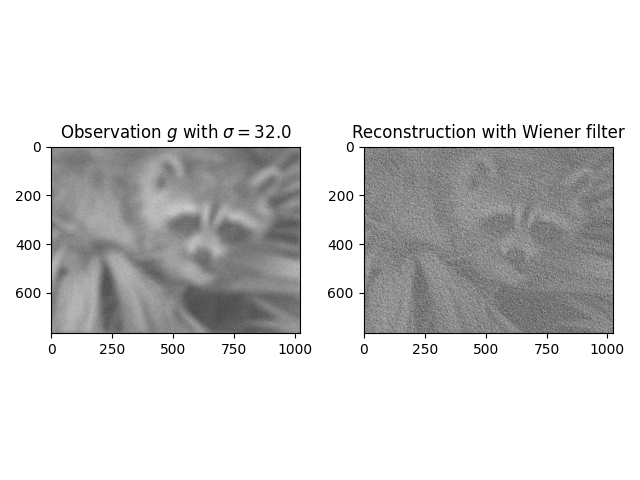

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [23]:
plt.figure()
interact(lambda i: plot_wiener_filter_result(i), i=widgets.IntSlider(min=(min_i:=0),max=(max_i:=len(wiener_reconsts)-1), step=1, value=0))

## Richardson-Lucy algorithm

Implement both, the gradient descent-based and the multiplicative version of the RL-algorithm. Try different step sizes and be patient with the number of iterations (maybe think of a way to accelerate convolutions that we learned in the lecture).

### Gradient-based RL

$\begin{align} 
  \hat{s}_{i+1} = \hat{s}_i - \eta \nabla J(s_i) = \hat{s}_i - \eta \left( 1 - \frac{g}{s_i*h} \right) * h^\intercal \,.
\end{align}$

In [25]:
def grad_RL(img:np.ndarray, kernel:np.ndarray, lr:float, n_iter:int):
    s_old = np.float32(img)
    s_list = []
    diff_list = []
    
    for i in range(0,n_iter):
        s_new = s_old - lr * fourier_conv((1 - img/fourier_conv(s_old,kernel)), kernel.transpose())
        diff = np.sum(np.abs(s_new - s_old))
        diff_list.append(diff)
        print(diff)
        s_list.append(s_new)
        s_old = s_new
        plt.imshow(s_old, cmap='gray')
    
    return s_old, s_list
        

Results for no noise, learning rate of 15 and 400 Iterations:

In [67]:
shat_list_grad_rl = np.load("ex4_grad_rl_noise_0.npy")

<IPython.core.display.Javascript object>


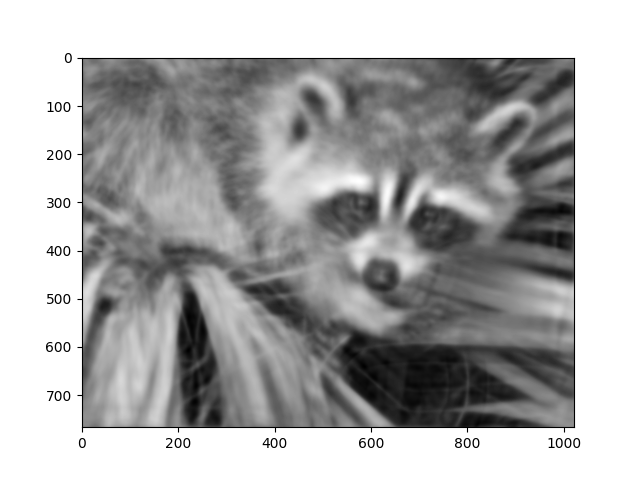

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [68]:
plt.figure()
interact(lambda i: plt.imshow(shat_list_grad_rl[i], cmap='gray'), i=widgets.IntSlider(min=0, max=len(shat_list_grad_rl)-1, step=1, value=0))

### Multiplicative RL

$\begin{align} 
  \hat{s}_{i+1} &= \hat{s}_i \frac{g}{\hat{s}_i*h}*h^\intercal \,.
\end{align}$

In [51]:
def mult_RL(img:np.ndarray, kernel:np.ndarray, n_iter:int):
    s_old = np.float32(img)
    s_list = []
    diff_list = []
    
    for i in range(0,n_iter):
        s_new = s_old * fourier_conv(img / fourier_conv(s_old, kernel), kernel.transpose())
        diff = np.sum(np.abs(s_new - s_old))
        diff_list.append(diff)
        print(diff)
        s_list.append(s_new)
        s_old = s_new
    
    return s_old, s_list
        

Results for no noise and 400 iterations:

In [69]:
shat_list_mult_rl_noise_0 = np.load("ex4_mult_rl_noise_0.npy")

<IPython.core.display.Javascript object>


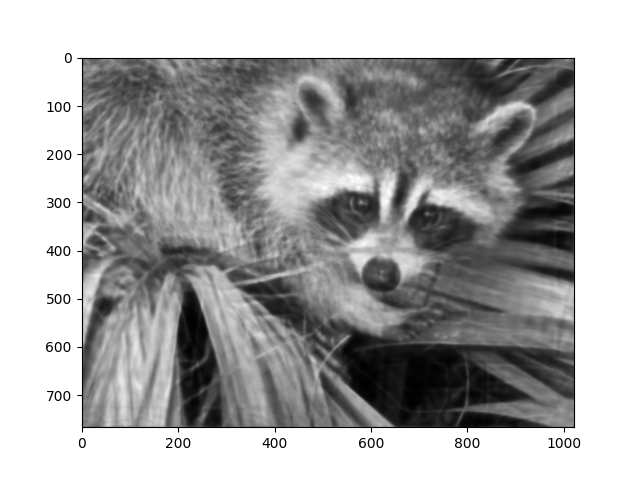

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [70]:
plt.figure()
interact(lambda i: plt.imshow(shat_list_mult_rl_noise_0[i], cmap='gray'), i=widgets.IntSlider(min=0, max=len(shat_list_mult_rl_noise_0)-1, step=1, value=0))

Results for noise with $\sigma = 4$ and 400 iterations:

In [72]:
shat_list_mult_rl_noise_4 = np.load("ex4_mult_rl_noise_4.npy")

<IPython.core.display.Javascript object>


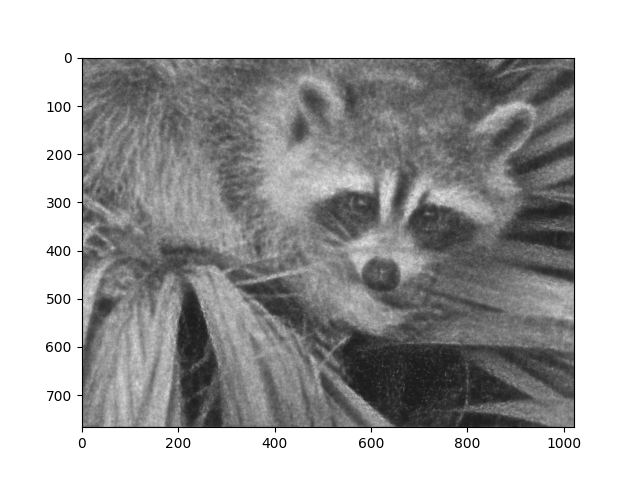

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [73]:
plt.figure()
interact(lambda i: plt.imshow(shat_list_mult_rl_noise_4[i], cmap='gray'), i=widgets.IntSlider(min=0, max=len(shat_list_mult_rl_noise_4)-1, step=1, value=0))

##### Archive

In [47]:
shat_grad_rl, shat_list_grad_rl = grad_RL(np.float32(noises[0]), np.float32(h), 15, 400)

116995.72364558777
110777.91535904977
105566.13855630021
101084.5620692148
97106.79125769841
93501.98359542368
90198.5118671683
87154.49939851028
84344.07050804675
81752.61278440926
79356.53816711617
77132.53255979768
75060.37212116164
73118.52446233957
71290.65549693337
69563.25610985885
67925.01113532444
66367.76981253082
64886.15549980556
63475.24156889691
62129.95777170596
60845.76869950232
59619.56792570157
58449.111026751656
57331.96720394439
56266.88361131119
55254.3036259876
54299.60058983598
53422.26726497253
52697.12650167772
52888.69805295693
95344.94699880773
121866.36362357094
151940.8885998897
247219.93698899317
146396.72743017858
99710.74313839071
144423.5726611694
134863.3473895294
204427.3430034153
157327.492539795
145482.05351120865
211301.298280592
106698.38305173097
512460.2793181181
172165.11956552175
302568.87401666836
382326.1752031896
147380.38180152958
98932.91829417151
186357.1014693605
217971.80067681952
121229.56496841091
124392.15920307687
198267.0980352857

In [37]:
a=shat_list_grad_rl[0::50]

In [48]:
a=shat_list_grad_rl

In [45]:
len(a)

400

In [41]:
np.save('ex4_grad_rl_noise_32', shat_list_grad_rl[0::50])

<IPython.core.display.Javascript object>


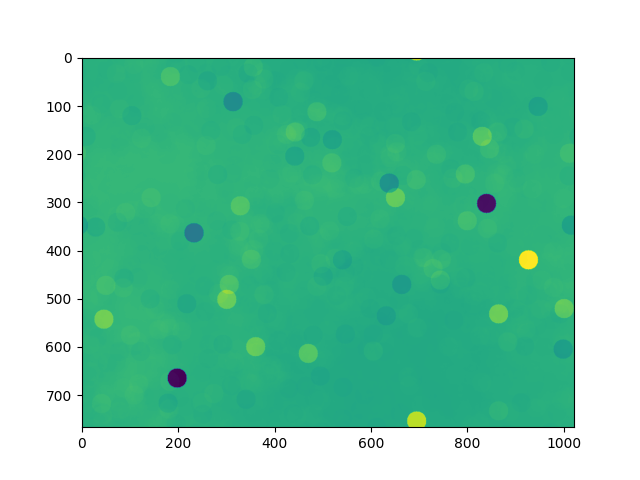

In [42]:
plt.figure()
plt.imshow(shat_grad_rl)

<IPython.core.display.Javascript object>


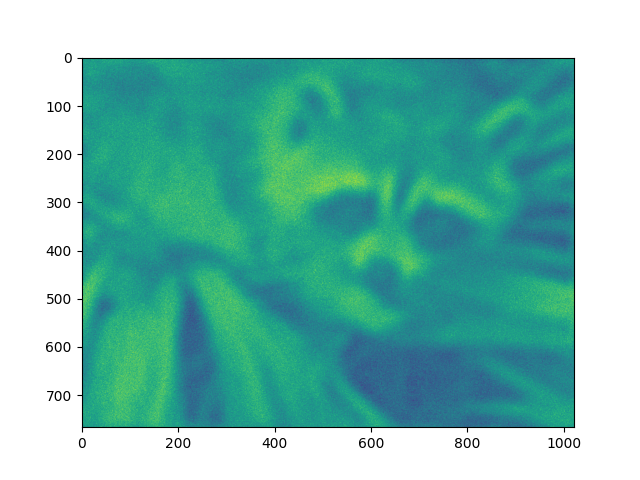

interactive(children=(IntSlider(value=0, description='i', max=399), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i)>

In [49]:
plt.figure()
interact(lambda i: plt.imshow(a[i]), i=widgets.IntSlider(min=0, max=len(a)-1, step=1, value=0))

In [52]:
shat_mult_rl_noise_0, shat_list_mult_rl_noise_0 = mult_RL(np.float32(noises[0]), np.float32(h), 400)

1975194.0111580864
1013845.4913791661
683335.9789168164
510664.7377757238
405361.4029324012
334715.5467090184
284513.7013372
247332.17414203967
218874.23491358254
196595.96431209156
178795.3155092561
164302.61015750802
152300.76228296553
142238.8451982955
133718.70144784794
126418.05826001012
120089.63501325941
114555.5816194866
109673.26060841186
105330.314757239
101436.27079085472
97918.40928071868
94720.48266507103
91795.91966141455
89107.98252241511
86625.14049614886
84322.56385804377
82176.31480209912
80167.68741927287
78280.7473522225
76500.94118763204
74818.30051892054
73222.55225464825
71705.61905128621
70259.50536404719
68877.8374029767
67554.70774339994
66285.54212899927
65065.910188682734
63892.04464412352
62760.827196691345
61669.5313818499
60615.21688978247
59595.6123392399
58608.61687784417
57652.34674172104
56725.10981905484
55825.136224758935
54951.29943220795
54102.22349210017
53276.7240853727
52473.581106900325
51691.64799307768
50930.042739903234
50187.70409825391
49

In [64]:
sigmas[2]

4.0

In [61]:
shat_mult_rl_noise_4, shat_list_mult_rl_noise_4 = mult_RL(np.float32(noises[2]), np.float32(h), 400)

1974562.7085540858
1014072.7413138391
684085.7536709051
511916.8902840643
406865.57463097246
336405.44286072213
286376.9257968773
249351.35079738422
221072.13987291645
198984.56719392687
181369.83052039874
167044.66389535455
155216.6201688171
145328.4044829457
136956.79319444837
129784.06495592261
123581.73205479425
118166.0001954741
113396.16173495076
109159.31434063426
105363.75507197026
101940.6531389746
98834.43466980262
95996.59027804548
93388.65159063402
90979.72814014214
88742.67397120493
86657.73079619076
84706.9782372089
82874.63415574904
81146.82228325325
79513.1640859154
77964.30246754766
76492.01434829421
75089.64888903272
73751.03622347029
72470.17841815313
71242.81697472009
70064.62111670198
68931.75581964648
67840.96341077438
66789.75272373839
65775.44992905195
64795.719520444945
63848.47609077993
62931.59859604648
62043.37799828021
61182.26276601277
60346.68363699927
59535.44201033619
58747.35229864656
57981.27486354344
57236.23336133345
56511.121757720866
55805.2102454

<IPython.core.display.Javascript object>


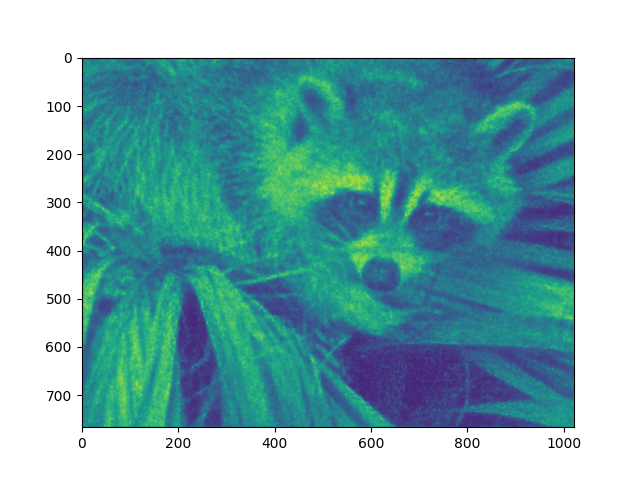

interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

In [63]:
plt.figure()
interact(lambda i: plt.imshow(a[i]), i=widgets.IntSlider(min=0, max=len(a)-1, step=1, value=0))

In [57]:
np.save('ex4_mult_rl_noise_0', shat_list_mult_rl_noise_0[0::50])

In [66]:
np.save('ex4_mult_rl_noise_4', shat_list_mult_rl_noise_32[0::50])